# **Projet Apprentissage Machine:** Analyse de performance académique (Student Performance Dataset – **Kaggle**) 

### **<u>Objectif:</u>**
1. Régression pour prédire les notes finales.
2. Classification (succès vs échec).
3. Clustering des profils d’étudiants. 
4. Ensembles pour combiner les prédictions.

### **Description du jeu de données**:
- Ce jeu de données contient les notes des étudiants au Lycée (États-Unis) pour certaines matières, et l'influence du bagage parentale sur les performances académiques.

  - _gender_           -            (female, male)
  - _race/ethnicity_       -        (group C, group D, group B, group E, group A)
  - _parental level of education_ - (some college, associate's degree, high school, some high school,bachelor's degree)
  - _lunch_           -             (standard, free/reduced)
  - _test preparation course_   -   (none, completed)
  - _math score_         -          (Between 0 and 100) 
  - _reading score_       -         (Between 17 and 100) 
  - _writing score_        -        (Between 10 and 100) 

## **1. Chargement et préparation des données**

### **<u>Tâches à faire</u>**:
1. Nettoyage, encodage des variables catégorielles, normalisation. 
2. Gestion des valeurs manquantes. 
3. Analyse descriptive des données.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA

import random
import os

In [2]:
# La reproductibilite
# La graine aleatoire
# au cas ou un utilisateur travail dans systeme different
SEED = 42
random.seed(SEED)
np.random.seed(seed=SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

### (a) Chargement des données

In [3]:
df = pd.read_csv("../data/StudentsPerformance.csv") # Update l'import du dataset
df.head(10)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
5,female,group B,associate's degree,standard,none,71,83,78
6,female,group B,some college,standard,completed,88,95,92
7,male,group B,some college,free/reduced,none,40,43,39
8,male,group D,high school,free/reduced,completed,64,64,67
9,female,group B,high school,free/reduced,none,38,60,50


### (b) Nettoyage des données

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [5]:
df.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [6]:
# Vérifie les doublons
df.duplicated().sum()

0

In [7]:
df.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


In [ ]:
#valeurs uniques
df.nunique()

gender                          2
race/ethnicity                  5
parental level of education     6
lunch                           2
test preparation course         2
math score                     81
reading score                  72
writing score                  77
dtype: int64

In [9]:
# sélection des colonnes catégoriel
## Definir `test preparation course` - comme cible..
categoriel_col = df.select_dtypes(exclude=["number"]).columns.drop('test preparation course')
categoriel_col

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch'], dtype='object')

In [10]:
# sélection des colonnes numerique
numerical_col = df.select_dtypes(exclude=["object"]).columns
numerical_col

Index(['math score', 'reading score', 'writing score'], dtype='object')

### (c) Encodage des colonnes catégorielles

In [11]:
# encodage des colonnes catégorielles
categoriel_df = df[categoriel_col]
print(f"Nombre de colonnes catégorielles à traiter: {len(categoriel_col)}")
categoriel_df.head(10)

Nombre de colonnes catégorielles à traiter: 4


,gender,race/ethnicity,parental level of education,lunch
0,female,group B,bachelor's degree,standard
1,female,group C,some college,standard
2,female,group B,master's degree,standard
3,male,group A,associate's degree,free/reduced
4,male,group C,some college,standard
5,female,group B,associate's degree,standard
6,female,group B,some college,standard
7,male,group B,some college,free/reduced
8,male,group D,high school,free/reduced
9,female,group B,high school,free/reduced


### (d) One Hot Encoding (OHE)

In [12]:
# one hot encoding pour la colonne gender et test preparation course

# 1 - OHE des caractéristiques `gender`, `lunch` #### et `test preparation course`
categoriel_df = pd.get_dummies(categoriel_df, columns=['gender', 'lunch',]) # 'test preparation course'])
categoriel_df.head()

,race/ethnicity,parental level of education,gender_female,gender_male,lunch_free/reduced,lunch_standard
0,group B,bachelor's degree,True,False,False,True
1,group C,some college,True,False,False,True
2,group B,master's degree,True,False,False,True
3,group A,associate's degree,False,True,True,False
4,group C,some college,False,True,False,True


### (e) Ordinal Encoder (OE)

In [13]:
#encodage ordinal

# 2 - OE de la caractéristique `parental level of education`
# L'ordre défini est important
# Conserve l'importance de chaque niveau d'éducation des parents.

encodage = OrdinalEncoder(categories=[["high school", "some high school", "some college", "associate's degree", "bachelor's degree", "master's degree"]])
encodage.fit(categoriel_df[['parental level of education']])
categoriel_df['parental level of education'] = encodage.transform(categoriel_df[['parental level of education']])

categoriel_df

# 0 = high school
# 1 = some high school
# 2 = some college
# 3 = associate's degree
# 4 = bachelor's degree
# 5 = master's degree

,race/ethnicity,parental level of education,gender_female,gender_male,lunch_free/reduced,lunch_standard
0,group B,4.0,True,False,False,True
1,group C,2.0,True,False,False,True
2,group B,5.0,True,False,False,True
3,group A,3.0,False,True,True,False
4,group C,2.0,False,True,False,True
...,...,...,...,...,...,...
995,group E,5.0,True,False,False,True
996,group C,0.0,False,True,True,False
997,group C,0.0,True,False,True,False
998,group D,2.0,True,False,False,True


### (f) Encodage de fréquence (FE)

In [14]:
# Encodage de fréquence

# 3 - `FE` de la caractéristique `race/ethnicity`
encodage_freq = categoriel_df['race/ethnicity'].value_counts(normalize=True)
categoriel_df['race/ethnicity'] = categoriel_df['race/ethnicity'].map(encodage_freq)
categoriel_df.head()

,race/ethnicity,parental level of education,gender_female,gender_male,lunch_free/reduced,lunch_standard
0,0.190,4.0,True,False,False,True
1,0.319,2.0,True,False,False,True
2,0.190,5.0,True,False,False,True
3,0.089,3.0,False,True,True,False
4,0.319,2.0,False,True,False,True


### ~~(g) Encodage de cible (TE)~~

In [15]:
# encodage de cible
# aucun besoin d'encoder par cible car il n'existe aucune cible apparente
# avec laquelle associer notre variable à encoder.

# 4 - La caractéristique `lunch` est encodée plus haut, par OHE et non OE car il n'y a pas 
# réellement de relation d'ordre entre les catégories `['standard', 'free/reduced']`

# df_encodage_cible = pd.DataFrame({'lunch': ['standard', 'free/reduced'], 'target': [0,1]})
# mean_cb = df_encodage_cible.groupby('lunch')['target'].mean()
# df['lunch'] = df['lunch'].map(mean_cb)
# df

### (h) Normalisation/Standardisation des données

In [16]:
# L'encodage ordinal a créer des colonnes numériques
# Fusionner les colonnes catégorielles et numériques
numerical_df = df[numerical_col]
clean_df = pd.concat([categoriel_df, numerical_df], axis=1) # Fusionner `categoriel_df` et `numerical_df`
print(f'Taille des données nettoyées: {clean_df.shape}\n')

clean_df.head() # Apercu


Taille des données nettoyées: (1000, 9)



,race/ethnicity,parental level of education,gender_female,gender_male,lunch_free/reduced,lunch_standard,math score,reading score,writing score
0,0.190,4.0,True,False,False,True,72,72,74
1,0.319,2.0,True,False,False,True,69,90,88
2,0.190,5.0,True,False,False,True,90,95,93
3,0.089,3.0,False,True,True,False,47,57,44
4,0.319,2.0,False,True,False,True,76,78,75


In [32]:
# Avec `MinMaxScaler`
min_max_scaler = MinMaxScaler()
min_max_scaler.set_output(transform="pandas") # Utilisation de pandas


donnees_normaliser = min_max_scaler.fit_transform(clean_df)
print(f'Données scalées avec `MinMax`, aperću: \n\n{donnees_normaliser.head()}')

Données scalées avec `MinMax`, aperću: 

   race/ethnicity  parental level of education  gender_female  gender_male  \
0         0.43913                          0.8            1.0          0.0   
1         1.00000                          0.4            1.0          0.0   
2         0.43913                          1.0            1.0          0.0   
3         0.00000                          0.6            0.0          1.0   
4         1.00000                          0.4            0.0          1.0   

   lunch_free/reduced  lunch_standard  math score  reading score  \
0                 0.0             1.0        0.72       0.662651   
1                 0.0             1.0        0.69       0.879518   
2                 0.0             1.0        0.90       0.939759   
3                 1.0             0.0        0.47       0.481928   
4                 0.0             1.0        0.76       0.734940   

   writing score  
0       0.711111  
1       0.866667  
2       0.922222  
3    

In [36]:
# Avec `StandardScaler`
standard_scaler = StandardScaler()
standard_scaler.set_output(transform="pandas")


donnees_standardisees = standard_scaler.fit_transform(clean_df)
print(f'Données scalées avec `StandardScaler`, aperću: \n\n{donnees_standardisees.head()}')

Données scalées avec `StandardScaler`, aperću: 

   race/ethnicity  parental level of education  gender_female  gender_male  \
0       -0.569024                     1.310052       0.964625    -0.964625   
1        1.098265                    -0.043308       0.964625    -0.964625   
2       -0.569024                     1.986732       0.964625    -0.964625   
3       -1.874421                     0.633372      -1.036672     1.036672   
4        1.098265                    -0.043308      -1.036672     1.036672   

   lunch_free/reduced  lunch_standard  math score  reading score  \
0           -0.741881        0.741881    0.390024       0.193999   
1           -0.741881        0.741881    0.192076       1.427476   
2           -0.741881        0.741881    1.577711       1.770109   
3            1.347925       -1.347925   -1.259543      -0.833899   
4           -0.741881        0.741881    0.653954       0.605158   

   writing score  
0       0.391492  
1       1.313269  
2       1.642475

## **2. Analyse exploratoire et visualisation**

### **<u>Tâches à faire</u>**:
1. Visualisations des distributions et corrélations. 
2. Graphiques par classes, regroupements, ou tendances temporelles (si 
applicable).

### Effectuons l'analyse exploratoire sur les données prétraitées (`clean_df`).
Le prétraitement ne modifie en rien la pertinence des données. Elle les mets sous une forme plus pratique pour les modèles.

In [38]:
# Aperću de `clean_df`
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   race/ethnicity               1000 non-null   float64
 1   parental level of education  1000 non-null   float64
 2   gender_female                1000 non-null   bool   
 3   gender_male                  1000 non-null   bool   
 4   lunch_free/reduced           1000 non-null   bool   
 5   lunch_standard               1000 non-null   bool   
 6   math score                   1000 non-null   int64  
 7   reading score                1000 non-null   int64  
 8   writing score                1000 non-null   int64  
dtypes: bool(4), float64(2), int64(3)
memory usage: 43.1 KB


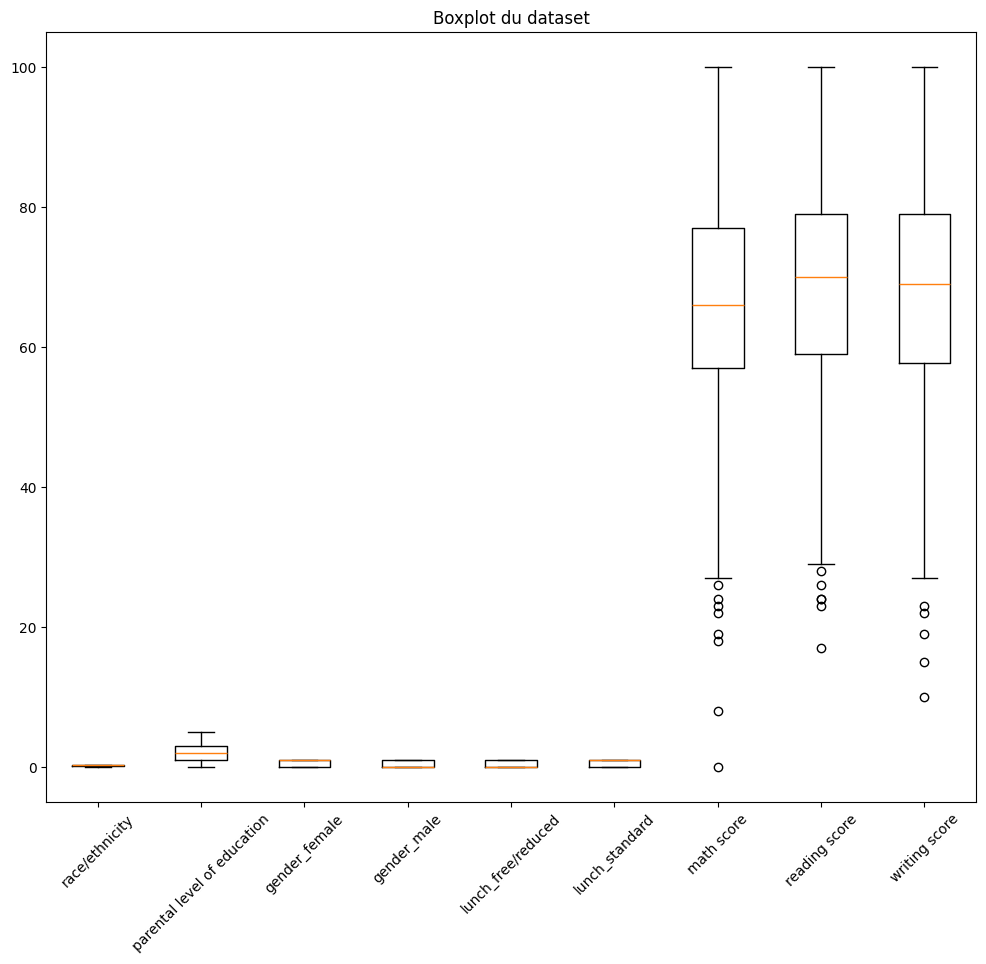

In [59]:
# colonnes_a_tracer = ['math score', 'reading score', 'writing score']
# plt.boxplot(clean_df[colonnes_a_tracer])
### Il y a dans chacun à peu près le même nombre de valeurs abérantes

plt.figure(figsize=(12, 10))
plt.title("Boxplot du dataset")
plt.boxplot(clean_df, labels=clean_df.columns) # Visualisation a partir de clean_df <- donnee nettoyees et en version numerique
plt.xticks(rotation=45)
plt.show()

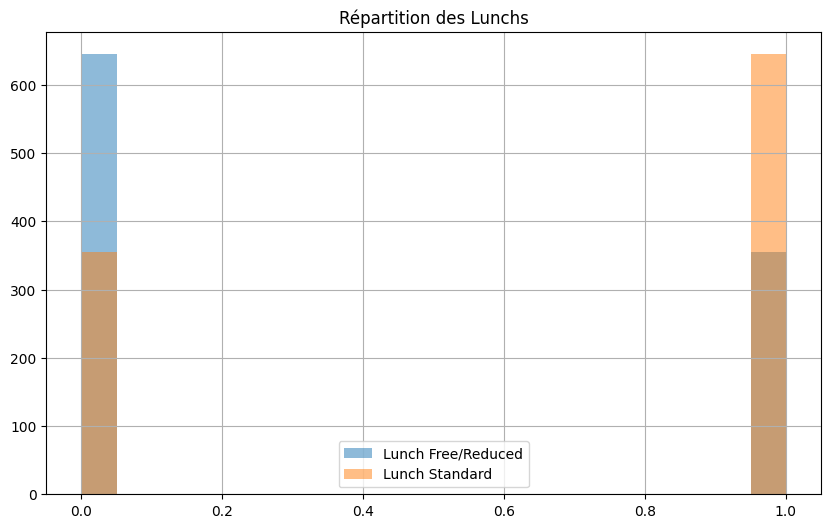

In [60]:
#histogramme pour représenter la répartion de chaque type de lunch
plt.figure(figsize=(10, 6))
plt.hist(clean_df['lunch_free/reduced'].astype(int), bins=20, alpha=0.5, label='Lunch Free/Reduced')
plt.hist(clean_df['lunch_standard'].astype(int), bins=20, alpha=0.5, label='Lunch Standard')

plt.title('Répartition des Lunchs')

plt.legend()
plt.grid()
plt.show()

### Corrélations

<Axes: >

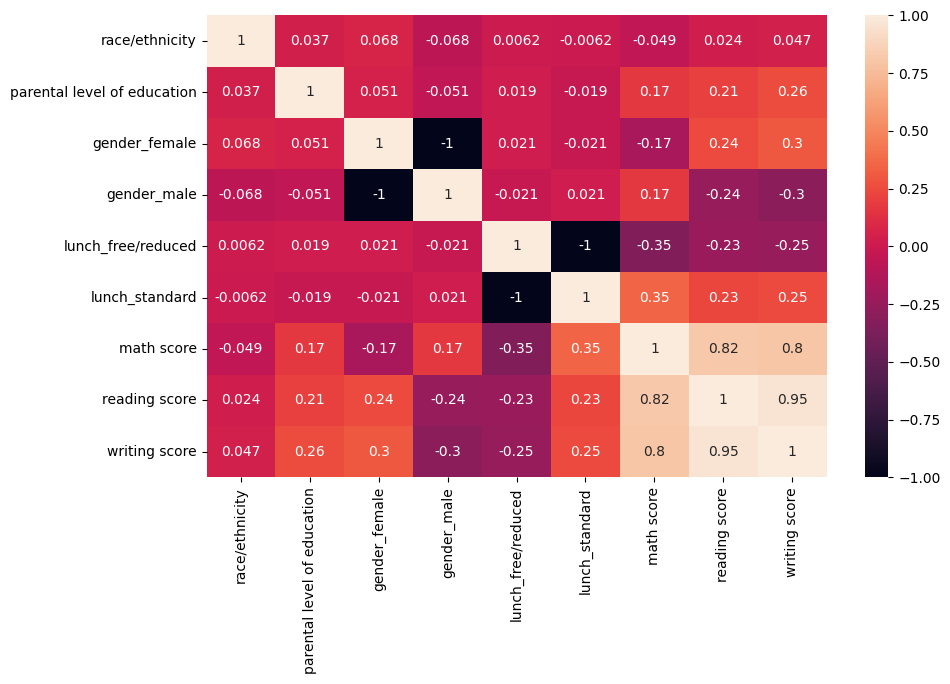

In [62]:
#matrice de corrélation de spearman
corr_matrix_pearson = clean_df.corr()
plt.figure(figsize=(10,6))

sns.heatmap(corr_matrix_pearson, annot=True)

In [48]:
# Notre cible choisie, ne beneficie plus d'un encodage
# clean_df['test preparation course_completed'].value_counts()

In [66]:
# Determiner la proportation des `race/ethnicity` -> Verifier s'il y a desequilibre
# En effet, groupe ethnique minoritaire <- donc variable encodee par frequence.
df['race/ethnicity'].value_counts()

race/ethnicity
group C    319
group D    262
group B    190
group E    140
group A     89
Name: count, dtype: int64

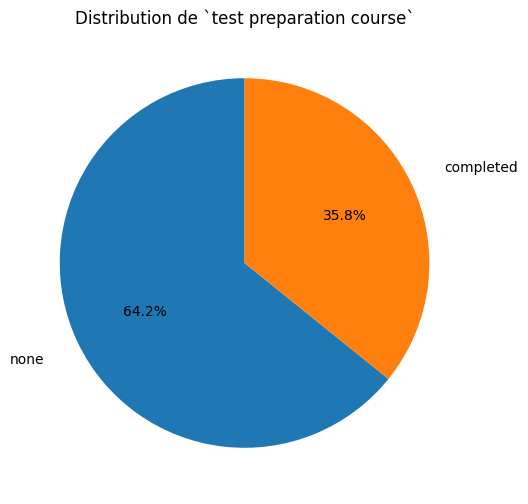

In [67]:
# diagramme circulaire de la colonne test preparation course completed

compte1 = df['test preparation course'].value_counts() # Possede 02 classes `None` et `Completed` <- depuis le `df` initial

plt.figure(figsize=(8,6))
# plt.pie(compte1.values, labels=compte1.index, autopct='%1.1f%%')
plt.pie(compte1.values, labels=compte1.index, autopct='%1.1f%%', startangle=90, labeldistance=1.2)
plt.title('Distribution de `test preparation course`')

plt.show()

In [69]:
# Le nombre d'étudiant est plus large dans le groupe '0.319' <- 'C'
df_mode_race_eth = df['race/ethnicity'].mode()
df_mode_race_eth

0    group C
Name: race/ethnicity, dtype: object

In [70]:
#histogramme pour la colonne 'parental level of education'
compte = df['parental level of education'].value_counts()
compte

parental level of education
some college          226
associate's degree    222
high school           196
some high school      179
bachelor's degree     118
master's degree        59
Name: count, dtype: int64

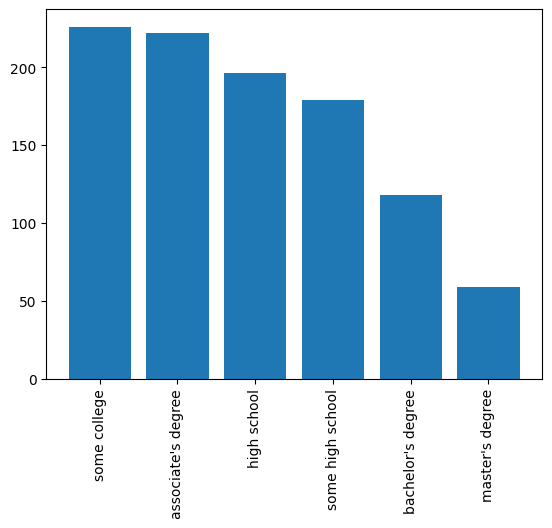

In [72]:
# Graphique en barre de la colonne 
plt.bar(compte.index, compte.values)
plt.xticks(rotation=90)
plt.show()

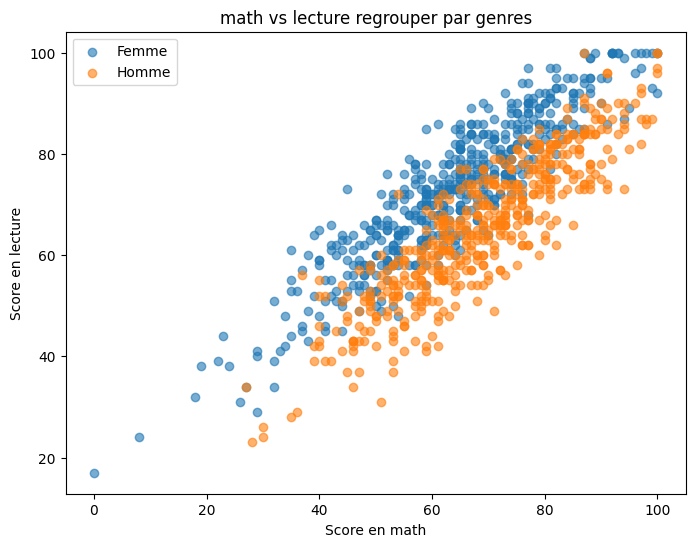

In [73]:
#Nuage de points : coloré par genre
plt.figure(figsize=(8,6))
plt.scatter(clean_df[clean_df['gender_female'] == 1]['math score'], clean_df[clean_df['gender_female'] == 1]['reading score'], label='Femme', alpha=0.6)
plt.scatter(clean_df[clean_df['gender_male'] == 1]['math score'], clean_df[clean_df['gender_male'] == 1]['reading score'], label='Homme', alpha=0.6)
plt.title("math vs lecture regrouper par genres")
plt.xlabel("Score en math")
plt.ylabel("Score en lecture")
plt.legend()
plt.show()

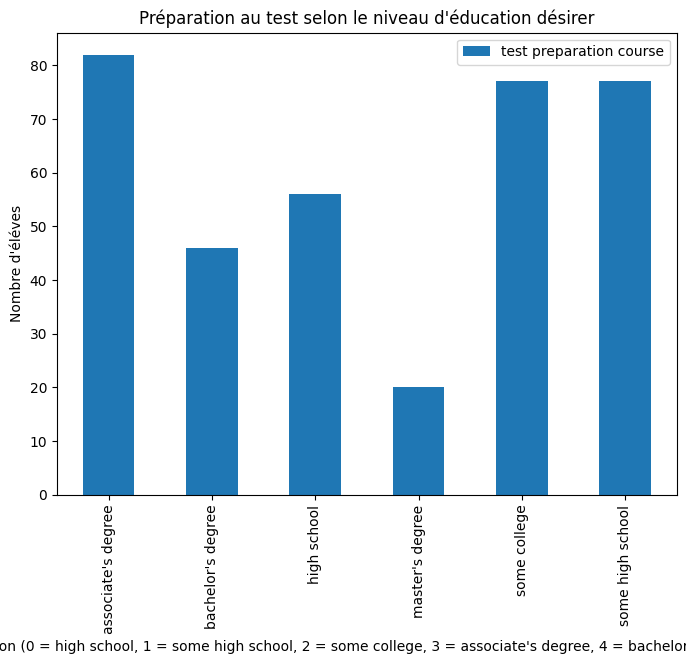

In [ ]:
# Diagramme à bande
#Création d'un tableau croisé
# prep_level_education = clean_df.groupby('parental level of education')[['test preparation course_completed', 'test preparation course_none']].sum()
df['test preparation course'] = df['test preparation course'].map({'none': 0, 'completed':1}) # Effectuer un mapping vers 0,1 de nos 02 classes
prep_level_education = df.groupby('parental level of education')[['test preparation course']].sum()


prep_level_education.plot(kind='bar', stacked=True, figsize=(8,6))
plt.title("Préparation au test selon le niveau d'éducation désirer")
plt.xlabel("Type de niveau d'éducation (0 = high school, 1 = some high school, 2 = some college, 3 = associate's degree, 4 = bachelor's degree, 5 = master's degree)")
plt.ylabel("Nombre d'éléves")
plt.show()

# Il y a plus d'étudiant qui ne se sont pas préparé à leur test.

## **Separation `train_test_split` pour `Classification`**

In [91]:
# Séparation des données
y = df["test preparation course"] # .map({'none': 0, 'completed': 1}) # cible de classification
X = df.drop(columns="test preparation course") # caracteristiques

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED, stratify=y) # Pour utilisation directe pour la classification
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X, y, test_size=0.25, random_state=SEED, stratify=y) # Pour utilisation dans pipeline


# **Définition de la pipeline de reproduction -> Pour pretraitement**

In [92]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

one_hot_columns = ['gender', 'lunch', 'race/ethnicity'] # ajout de la colonne 'race/ethnicity', 
# Car on ne peut pas utiliser Labelencoder dans un 'ColumnTransformer' <- pour un encodage sequentielle
ordinal_encoder_categories = ["high school", "some high school", "some college", "associate's degree", "bachelor's degree", "master's degree"]
ordinal_encoder_columns = ['parental level of education']
numerical_col = ['reading score', 'writing score'] # on enlève la math score, car c'est la variable cible pour la régression

#label_encoding_columns = ['race/ethnicity']


# preprocesseur categoriel
preprocessor_categoriel = ColumnTransformer(transformers=[     #### Preprocesseur categoriel pour utilisation directe et manuelle -- 
    ("one_hot", OneHotEncoder(sparse_output=False), one_hot_columns),
    ("ordinal", OrdinalEncoder(categories=[ordinal_encoder_categories]), ordinal_encoder_columns),
    ("scaler", StandardScaler(), numerical_col)
    #("label", LabelEncoder(), label_encoding_columns)
], remainder='passthrough')

preprocessor_categoriel_pipeline = ColumnTransformer(transformers=[         #### Preprocesseur categoriel pour utilisation depuis notre pipeline -- 
    ("one_hot", OneHotEncoder(sparse_output=False), one_hot_columns),
    ("ordinal", OrdinalEncoder(categories=[ordinal_encoder_categories]), ordinal_encoder_columns),
    # ("scaler", StandardScaler(), numerical_col)
    #("label", LabelEncoder(), label_encoding_columns)
], remainder='passthrough')

# pipeline standardiser
pipeline_scaler = Pipeline(steps=[
    ("preprocessing", preprocessor_categoriel_pipeline),
    ("scaler", StandardScaler())
])

#pipelines complet avec PCA standardisation et normalisation
pipeline_pca_scaler = Pipeline(steps=[
    ("preprocessing", preprocessor_categoriel_pipeline),
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=2))
])

pipeline_pca_minmax = Pipeline(steps=[
    ("preprocessing", preprocessor_categoriel_pipeline),
    ("min_max", MinMaxScaler()),
    ("pca", PCA(n_components=2))
])


# Affichage d'une pipeline X
pipeline_pca_minmax

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['gender', 'lunch',
                                                   'race/ethnicity']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['high '
                                                                              'school',
                                                                              'some '
                                                                              'high '
                                                                              'school',
                                                                              'some '
                                                                              'college',
                                                                              "associate's "
                                                                              'degree',
                                                                              "bachelor's "
                                                                              'degree',
                                                                              "master's "
                                                                              'degree']]),
                                                  ['parental level of '
                                                   'education'])])),
                ('min_max', MinMaxScaler()), ('pca', PCA(n_components=2))])

In [93]:
# Apercu du de nos donnees dentrainements - 
X_train.head()

,gender,race/ethnicity,parental level of education,lunch,math score,reading score,writing score
239,male,group C,associate's degree,standard,84,80,80
735,male,group C,master's degree,standard,67,57,59
259,female,group C,master's degree,free/reduced,65,81,81
516,female,group D,some college,standard,74,89,84
594,female,group C,bachelor's degree,standard,92,100,99


In [ ]:
# Pretraitement direct/manuel
X_train = preprocessor_categoriel.fit_transform(X_train)
X_test = preprocessor_categoriel.transform(X_test)  # avec transform on évite la fuite de données

array([[ 0.        ,  1.        ,  0.        , ...,  0.74304105,
         0.7930809 , 84.        ],
       [ 0.        ,  1.        ,  0.        , ..., -0.84859662,
        -0.59342417, 67.        ],
       [ 1.        ,  0.        ,  1.        , ...,  0.81224269,
         0.85910495, 65.        ],
       ...,
       [ 1.        ,  0.        ,  1.        , ...,  1.01984761,
         1.25524926, 71.        ],
       [ 0.        ,  1.        ,  1.        , ...,  1.3658558 ,
         1.45332141, 84.        ],
       [ 0.        ,  1.        ,  1.        , ...,  0.67383942,
         0.72705685, 80.        ]])

In [95]:
X_train # Pretraitee et normalisee ##### AFFICHAGE

array([[ 0.        ,  1.        ,  0.        , ...,  0.74304105,
         0.7930809 , 84.        ],
       [ 0.        ,  1.        ,  0.        , ..., -0.84859662,
        -0.59342417, 67.        ],
       [ 1.        ,  0.        ,  1.        , ...,  0.81224269,
         0.85910495, 65.        ],
       ...,
       [ 1.        ,  0.        ,  1.        , ...,  1.01984761,
         1.25524926, 71.        ],
       [ 0.        ,  1.        ,  1.        , ...,  1.3658558 ,
         1.45332141, 84.        ],
       [ 0.        ,  1.        ,  1.        , ...,  0.67383942,
         0.72705685, 80.        ]])

# **3. Modélisation supervisée**

### **<u>Tâches à faire</u>**:
1. Entraîner au moins deux modèles différents (ex. : régression 
linéaire/logistique, SVM, arbres de décision). 
2. Comparer les performances avec validation croisée et métriques adaptées 
(précision, rappel, RMSE, etc.).

## **Classification**

- ### **_Entrainement direct/manuel_**

In [100]:
#Entrainement de deux modèles (SVM, Arbre) pour la classification
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

modelSVM = SVC(kernel='linear', probability=True, random_state=SEED)
ModelArbre = DecisionTreeClassifier(random_state=SEED)

modelSVM.fit(X_train, y_train)
ModelArbre.fit(X_train, y_train)

pred_SVM = modelSVM.predict(X_test)
pred_Arbre = ModelArbre.predict(X_test)

score_svm = accuracy_score(y_test, pred_SVM)
score_arbre = accuracy_score(y_test, pred_Arbre)

precision_svm = precision_score(y_test, pred_SVM)
precision_arbre = precision_score(y_test, pred_Arbre)

recall_svm = recall_score(y_test, pred_SVM)
recall_arbre = recall_score(y_test, pred_Arbre)

print("Score (SVM): ", score_svm)
print("Score (Arbre): ", score_arbre)
print("Score de précision (SVM): ", precision_svm)
print("Score de précision (Arbre): ", precision_arbre)
print("rappel (SVM): ", recall_svm)
print("rappel (Arbre): ", recall_arbre)

print("\n\n Tableau comparatif des modeles tester..")
resultats = pd.DataFrame({
    "Modèle": ["SVM (linéaire)", "Arbre de décision"],
    "Accuracy": [score_svm, score_arbre],
    "Précision": [precision_svm, precision_arbre],
    "Rappel": [recall_svm, recall_arbre]
})

print(resultats)

Score (SVM):  0.776
Score (Arbre):  0.636
Score de précision (SVM):  0.746268656716418
Score de précision (Arbre):  0.49056603773584906
rappel (SVM):  0.5617977528089888
rappel (Arbre):  0.5842696629213483


 Tableau comparatif des modeles tester..
              Modèle  Accuracy  Précision    Rappel
0     SVM (linéaire)     0.776   0.746269  0.561798
1  Arbre de décision     0.636   0.490566  0.584270


- ### **_Entrainement avec pipeline_: cas de l'arbre de decision**

In [101]:
# Apercu de X_train_p -> donnees pour usage dans pipeline
X_train_p.head()

,gender,race/ethnicity,parental level of education,lunch,math score,reading score,writing score
239,male,group C,associate's degree,standard,84,80,80
735,male,group C,master's degree,standard,67,57,59
259,female,group C,master's degree,free/reduced,65,81,81
516,female,group D,some college,standard,74,89,84
594,female,group C,bachelor's degree,standard,92,100,99


### **Optimisation du modele d'Arbre de Decision - Pour classification**

In [107]:
from sklearn.model_selection import GridSearchCV # Se rassurer qu'il est importe

# Pipeline tree + preprocessor + scaling
pipeline_min_max_tree = Pipeline(steps=[
    ("preprocessing", preprocessor_categoriel),
    ("min_max", MinMaxScaler()),
    ("tree", DecisionTreeClassifier(random_state=SEED))
])

# Param grid pour GridSearchCV
param_grid = {
    "tree__criterion": ["gini", "entropy", "log_loss"],
    "tree__max_depth": [None, 3, 5, 10, 20],
    "tree__min_samples_split": [2, 5, 10],
    "tree__min_samples_leaf": [1, 2, 4, 8],
    "tree__max_features": [None, "sqrt", "log2"]
}

grid_search_tree = GridSearchCV(
    estimator=pipeline_min_max_tree,
    param_grid=param_grid,
    cv=5,                 
    n_jobs=-1,            
    scoring="f1"    # métrique d'optimisation - f1/ harmonisation entre precision et rappel
)

# Entraînement du GridSearch sur ton dataset prétraité
grid_search_tree.fit(X_train_p, y_train_p)

# Meilleurs paramètres trouvés
print("Meilleurs hyperparamètres :")
print(grid_search_tree.best_params_)

# Meilleur modèle
best_tree_model = grid_search_tree.best_estimator_

# Prédictions
pred_Arbre_pipeline = best_tree_model.predict(X_test_p)

# Scores finaux
print("\nScore optimal Accuracy :", accuracy_score(y_test_p, pred_Arbre_pipeline))
print("Précision :", precision_score(y_test_p, pred_Arbre_pipeline))
print("Rappel :", recall_score(y_test_p, pred_Arbre_pipeline))



Meilleurs hyperparamètres :
{'tree__criterion': 'entropy', 'tree__max_depth': 20, 'tree__max_features': None, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 2}

Score optimal Accuracy : 0.644
Précision : 0.5
Rappel : 0.5730337078651685


In [110]:
# Entrainement avec pipeline
#pipeline normaliser pour decision Tree
model_arbre = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=20,
    max_features=None,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=SEED
)

pipeline_min_max_tree = Pipeline(steps=[
    ("preprocessing", preprocessor_categoriel),
    ("min_max", MinMaxScaler()),
    ("tree", model_arbre)
])
#Entraînement de la pipeline
pipeline_min_max_tree.fit(X_train_p, y_train_p)
# score
print("Score pipeline arbre:", pipeline_min_max_tree.score(X_test_p, y_test_p))

#prédictions
pred_Arbre_pipeline = pipeline_min_max_tree.predict(X_test_p)

print("Score de précision (Arbre): ", precision_score(y_test_p, pred_Arbre_pipeline))
print("rappel (Arbre): ", recall_score(y_test_p, pred_Arbre_pipeline))
print("Score F1: ", f1_score(y_test_p, pred_Arbre_pipeline))

Score pipeline arbre: 0.644
Score de précision (Arbre):  0.5
rappel (Arbre):  0.5730337078651685
Score F1:  0.5340314136125655


In [111]:
#pipeline standardiser pour SVM
pipeline_scaler_svm= Pipeline(steps=[
    ("preprocessing", preprocessor_categoriel),
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel='rbf', probability=True, random_state=SEED))
])
#Entrainements
pipeline_scaler_svm.fit(X_train_p, y_train_p)
print("Score pipelin svm:", pipeline_scaler_svm.score(X_test_p, y_test_p))

#prédictions
pred_svm_pipeline = pipeline_scaler_svm.predict(X_test_p)

print("Score de précision (SVM): ", precision_score(y_test_p, pred_svm_pipeline))
print("rappel (SVM): ", recall_score(y_test_p, pred_svm_pipeline))

Score pipelin svm: 0.688
Score de précision (SVM):  0.6410256410256411
rappel (SVM):  0.2808988764044944


In [113]:
# Validaiton croisée
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

scores_SVM = cross_val_score(pipeline_scaler_svm, X_train_p, y_train_p, cv=kf, scoring='accuracy')
scores_Arbre = cross_val_score(pipeline_min_max_tree, X_train_p, y_train_p, cv=kf, scoring='accuracy')

## Obtention des performances generales moyennes - Generalisation des modeles
print("validation croisé (SVM) moyenne: ", f'{scores_SVM.mean():.2f} +/- {scores_SVM.std():.2f}')
print("validation croisé (Arbre) moyenne: ", f'{scores_Arbre.mean():.2f} +/- {scores_Arbre.std():.2f}')

validation croisé (SVM) moyenne:  0.65 +/- 0.03
validation croisé (Arbre) moyenne:  0.58 +/- 0.05


Le modèle SVM a le meilleur score de précision dans ce système de classfication et la validation croisé pour le SVM est plus grand donc il est plus robuste que l'arbre de décision. Il est donc idéal pour utiliser à long terme pour la classification.

## **Separation `train_test_split` pour `Regression`**

In [114]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

# Régression linéaire pour prédire le score en math
# Il faut effectuer la régression sur le 'df', pas le 'clean_df'

X = df.drop(columns=['math score', 'test preparation course']) #on enleve 'test preparation course', car ce n'est pas une variable explicative numérique et pour éviter les fuites de données
y_r = df['math score']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_r, test_size=0.20, random_state=SEED)

In [116]:
print(df.columns)

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')


In [115]:
print(clean_df.columns) ### Apercu des donnees pretraitees..

Index(['race/ethnicity', 'parental level of education', 'gender_female',
       'gender_male', 'lunch_free/reduced', 'lunch_standard', 'math score',
       'reading score', 'writing score'],
      dtype='object')


In [117]:
# pipeline linéaire de régression

pipe_LR = Pipeline([
    ("preprocessing", preprocessor_categoriel),
    ("scaler", StandardScaler()),
    ("LinearRegression", LinearRegression())
])

pipe_LR.fit(X_train_r, y_train_r)

pred_Linear = pipe_LR.predict(X_test_r)

print("MSE", mean_squared_error(y_test_r, pred_Linear))
print("R2", r2_score(y_test_r, pred_Linear))
print("RMSE", root_mean_squared_error(y_test_r, pred_Linear))

MSE 32.31479803909228
R2 0.867202225217671
RMSE 5.6846106321446745


In [118]:
# pipelines pour ridge (L2) et Lasso (L1)
pipe_Ridge = Pipeline([
    ("preprocessing", preprocessor_categoriel),
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1))
])

pipe_Lasso = Pipeline([
    ("preprocessing", preprocessor_categoriel),
    ("scaler", StandardScaler()),
    ("lasso", Lasso(alpha=0.1))
])

pipe_Ridge.fit(X_train_r, y_train_r)

pipe_Lasso.fit(X_train_r, y_train_r)

pred_ridge = pipe_Ridge.predict(X_test_r)
pred_lasso = pipe_Lasso.predict(X_test_r)

print("Ridge")
print("MSE", mean_squared_error(y_test_r, pred_ridge))
print("R2", r2_score(y_test_r, pred_ridge))
print("RMSE", root_mean_squared_error(y_test_r, pred_ridge))

print("\n")
print("Lasso")
print("MSE", mean_squared_error(y_test_r, pred_lasso))
print("R2", r2_score(y_test_r, pred_lasso))
print("RMSE", root_mean_squared_error(y_test_r, pred_lasso))

Ridge
MSE 32.288793357759026
R2 0.8673090915459335
RMSE 5.682322883976149


Lasso
MSE 32.0180139621762
R2 0.8684218604125933
RMSE 5.658446249826555


### **Optimisation des modeles de regression - `` **

In [119]:
# Utilisation de GridSearch pour trouver le meilleur alpha pour le ridge et le lasso
param_grid_R= {
    "ridge__alpha": [0.1, 1, 5, 10, 50, 100]
}

grid_ridge = GridSearchCV(pipe_Ridge, param_grid=param_grid_R, cv=5, scoring="r2")

grid_ridge.fit(X_train_r, y_train_r)
print("Ridge")
print("Meilleurs paramètres :", grid_ridge.best_params_)
print("Meilleur score cv (r2) :", grid_ridge.best_score_)

param_grid_L = {
    "lasso__alpha": [0.1, 1, 5, 10, 50, 100]
}

grid_lasso = GridSearchCV(pipe_Lasso, param_grid=param_grid_L, cv=5, scoring="r2")

grid_lasso.fit(X_train_r, y_train_r)
print("Lasso")
print("Meilleurs paramètres :", grid_lasso.best_params_)
print("Meilleur score cv (r2) :", grid_lasso.best_score_)

Ridge
Meilleurs paramètres : {'ridge__alpha': 1}
Meilleur score cv (r2) : 0.861686380717004
Lasso
Meilleurs paramètres : {'lasso__alpha': 0.1}
Meilleur score cv (r2) : 0.861676966485096


In [52]:
# Validaiton croisée
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

scores_ridge = cross_val_score(pipe_Ridge, X_train_p, y_train_p, cv=kf, scoring='r2')
scores_lasso = cross_val_score(pipe_Lasso, X_train_p, y_train_p, cv=kf, scoring='r2')

print("validation croisé (ridge) moyenne: ", f'{scores_ridge.mean():.2f} +/- {scores_ridge.std():.2f}')
print("validation croisé (Lasso) moyenne: ", f'{scores_lasso.mean():.2f} +/- {scores_lasso.std():.2f}')

validation croisé (ridge) moyenne:  0.19 +/- 0.04
validation croisé (Lasso) moyenne:  0.03 +/- 0.01


In [ ]:
plt.bar()

Le score de ridge est meilleur que le score de lasso et la régression Linéaire, car le R2 score est meilleur et la moyenne de la validation croisée est plus robuste.

### **4. Modélisation non supervisée (clustering)**

### **<u>Tâches à faire</u>:**
1. Appliquer au moins une méthode de clustering (k-means, DBSCAN, 
hiérarchique). 
2. Interpréter les résultats et comparer la qualité des clusters.

In [44]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, HDBSCAN
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score

# Clustering K-means

for k in range(2,10): 
    kmeans = KMeans(n_clusters=k, random_state=SEED)
    pred_kmeans = kmeans.fit_predict(X_train)

    # Évaluation avec CH, Silhouette, DB
    print(f"\nNombre de clusters: {k}")
    print(f"CH: , {calinski_harabasz_score(X_train, pred_kmeans):.2f}")
    print(f"Silhouette: , {silhouette_score(X_train, pred_kmeans):.3f}")
    print(f"Davies-Bouldin: , {davies_bouldin_score(X_train, pred_kmeans):.3f}")

# Le k=9 donne le mieux score.


Nombre de clusters: 2


c:\Users\danie\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\danie\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 199, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\danie\miniconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\danie\miniconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\danie\miniconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProc

CH: , 1257.34
Silhouette: , 0.528
Davies-Bouldin: , 0.638

Nombre de clusters: 3
CH: , 1419.33
Silhouette: , 0.489
Davies-Bouldin: , 0.624

Nombre de clusters: 4
CH: , 1558.76
Silhouette: , 0.458
Davies-Bouldin: , 0.642


c:\Users\danie\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\danie\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\danie\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(



Nombre de clusters: 5
CH: , 1694.14
Silhouette: , 0.447
Davies-Bouldin: , 0.659

Nombre de clusters: 6
CH: , 1736.31
Silhouette: , 0.414
Davies-Bouldin: , 0.700

Nombre de clusters: 7
CH: , 1845.66
Silhouette: , 0.411
Davies-Bouldin: , 0.690


c:\Users\danie\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\danie\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\danie\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(



Nombre de clusters: 8
CH: , 1940.02
Silhouette: , 0.391
Davies-Bouldin: , 0.718

Nombre de clusters: 9
CH: , 1950.76
Silhouette: , 0.380
Davies-Bouldin: , 0.753


c:\Users\danie\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\danie\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\danie\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\danie\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Wi

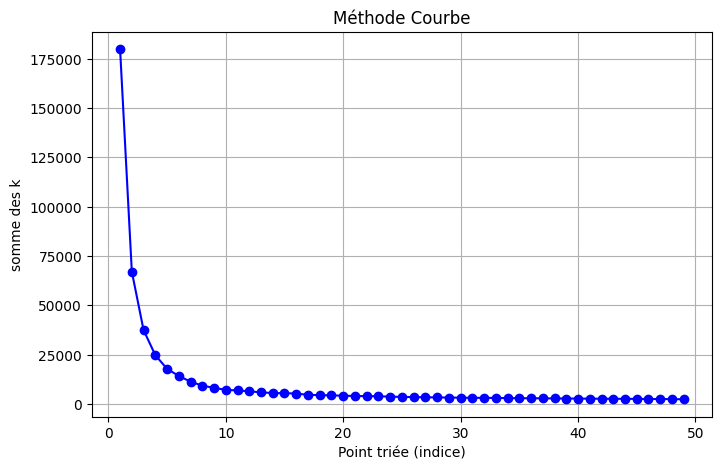

In [45]:
inertia = []

K_range = range(1,50)

for k in K_range:
    kmeans= KMeans(n_clusters=k, random_state=SEED)
    pred_kmeans = kmeans.fit(X_train)
    inertia.append(kmeans.inertia_)
    pass

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o', color='b')
plt.title("Méthode Courbe")
plt.xlabel("Point triée (indice)")
plt.ylabel("somme des k")
plt.grid()

In [46]:
#Calcul du DBSCAN
dbscan = DBSCAN(eps=2.3, min_samples=11)

pred_db = dbscan.fit_predict(X_train)

print("CH: ", calinski_harabasz_score(X_train, pred_db))
print("Silhouette: ", silhouette_score(X_train, pred_db))
print("Davies-Bouldin: ", davies_bouldin_score(X_train, pred_db))

# Le score est mieux avec les hyperparamètres (eps=2.3 et min_samples=11)

CH:  102.7350447986144
Silhouette:  0.2126200170194533
Davies-Bouldin:  3.408614986541824


In [47]:
#nombre de clusters trouvé
print("Clusters uniques:", np.unique(pred_db))

Clusters uniques: [-1  0  1]


In [48]:
# Clustering hiérarchique agglomératif
ward=AgglomerativeClustering(n_clusters=k, linkage='ward')
labels_ward = ward.fit_predict(X_train)

print("Ward:")
print("CH: ", calinski_harabasz_score(X_train, labels_ward))
print("Silhouette: ", silhouette_score(X_train, labels_ward))
print("Davies-Bouldin: ", davies_bouldin_score(X_train, labels_ward))

Ward:
CH:  1015.2426423499011
Silhouette:  0.17758684843286254
Davies-Bouldin:  1.3274072395901195


**5. Méthode d'ensembles** 

In [49]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier

# Foret aléatoire
RFC = RandomForestClassifier()
RFC.fit(X_train, y_train)

pred_rf = RFC.predict(X_test)

print("accuracy_score: ", accuracy_score(y_test, pred_rf))
print("précision de score: ", precision_score(y_test, pred_rf))
print("rappel: ", recall_score(y_test, pred_rf))

accuracy_score:  0.708
précision de score:  0.6290322580645161
rappel:  0.43820224719101125


In [50]:
# Gradient boosting
BO = GradientBoostingClassifier()
BO.fit(X_train, y_train)

pred_bo = BO.predict(X_test)

print("accuracy_score: ", accuracy_score(y_test, pred_bo))
print("précision de score: ", precision_score(y_test, pred_bo))
print("rappel: ", recall_score(y_test, pred_bo))

accuracy_score:  0.704
précision de score:  0.6086956521739131
rappel:  0.47191011235955055


In [51]:
# Bagging Classifier
BA = BaggingClassifier()
BA.fit(X_train, y_train)
pred_ba = BA.predict(X_test)

print("accuracy_score: ", accuracy_score(y_test, pred_ba))
print("précision de score: ", precision_score(y_test, pred_ba))
print("rappel: ", recall_score(y_test, pred_ba))

accuracy_score:  0.704
précision de score:  0.6056338028169014
rappel:  0.48314606741573035


Le modèles de forêt aléatoire fonctionne mieux que les autre modèles d'ensemble, car les données sont bruyantes et elles ont besoin de robustesse. Il est en plus très stable.